In [2]:
#imports
import numpy as np
import os
import sys
import math
import random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import requests
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import kagglehub
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import os
import time
import datetime

In [3]:
#loading datasets
download_path = kagglehub.dataset_download("olgaparfenova/daisee")

print("Dataset downloaded to:", download_path)
print("Files:", os.listdir(download_path))

Dataset downloaded to: C:\Users\USER\.cache\kagglehub\datasets\olgaparfenova\daisee\versions\1
Files: ['DAiSEE']


In [4]:
SAMPLE_EVERY_SECONDS = 10
CAMERA_INDEX = 0  # try 1 if 0 doesn't work

In [6]:
MODEL_URL = (
    "https://storage.googleapis.com/mediapipe-models/face_detector/"
    "blaze_face_short_range/float16/latest/blaze_face_short_range.tflite"
)
MODEL_PATH = "blaze_face_short_range.tflite"

def ensure_model(path=MODEL_PATH, url=MODEL_URL):
    if os.path.exists(path):
        return path
    print("Downloading MediaPipe face model...")
    r = requests.get(url, stream=True, timeout=60)
    r.raise_for_status()
    with open(path, "wb") as f:
        for chunk in r.iter_content(chunk_size=1 << 20):
            if chunk:
                f.write(chunk)
    print("Saved model to:", path)
    return path

def create_face_detector():
    model_path = ensure_model()
    base_options = python.BaseOptions(model_asset_path=model_path)
    options = vision.FaceDetectorOptions(base_options=base_options)
    return vision.FaceDetector.create_from_options(options)

def detect_and_draw_box_tasks(detector, frame_bgr):
    # MediaPipe Tasks expects RGB
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    result = detector.detect(mp_image)
    if not result.detections:
        return frame_bgr, False

    # take best detection by confidence
    best = max(result.detections, key=lambda d: d.categories[0].score)
    bbox = best.bounding_box  # pixel coords
    x1, y1 = int(bbox.origin_x), int(bbox.origin_y)
    x2, y2 = x1 + int(bbox.width), y1 + int(bbox.height)

    h, w = frame_bgr.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w - 1, x2), min(h - 1, y2)

    out = frame_bgr.copy()
    cv2.rectangle(out, (x1, y1), (x2, y2), (0, 255, 0), 2)

    score = best.categories[0].score
    cv2.putText(out, f"Face {score:.2f}", (x1, max(0, y1 - 10)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    return out, True


Live webcam started. Press 'q' in the video window to quit.
[1767538988.86] No face detected ❌
[1767538998.88] Face detected ✅


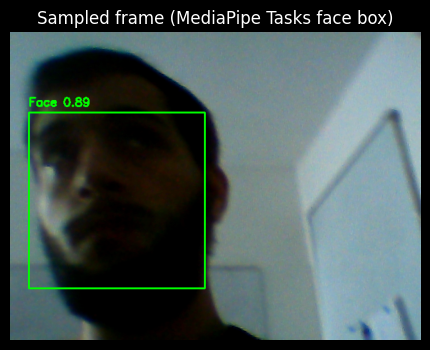

[1767539008.96] Face detected ✅


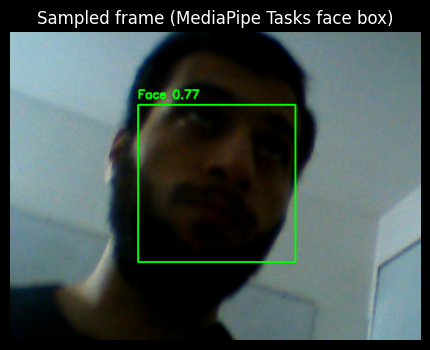

[1767539019.04] Face detected ✅


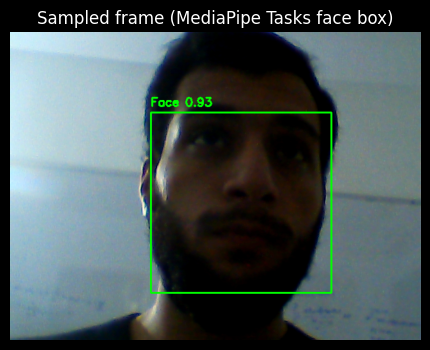

[1767539029.12] Face detected ✅


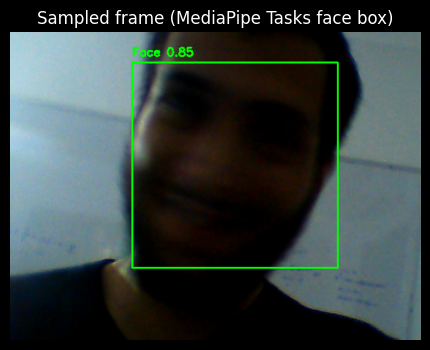

[1767539039.20] Face detected ✅


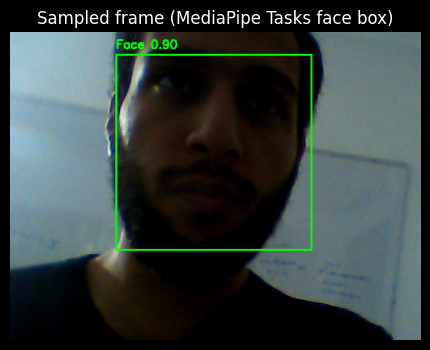

[1767539049.20] Face detected ✅


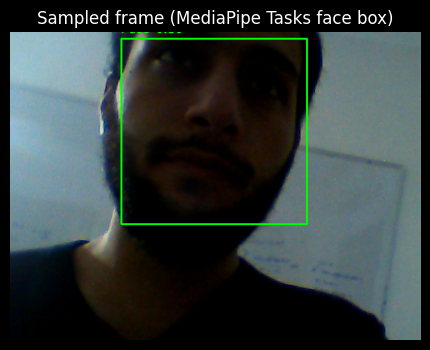

[1767539059.28] No face detected ❌
[1767539069.33] No face detected ❌
[1767539079.33] No face detected ❌
[1767539089.35] No face detected ❌
[1767539099.39] No face detected ❌
[1767539109.39] No face detected ❌
[1767539119.41] No face detected ❌
[1767539129.46] No face detected ❌
[1767539139.47] No face detected ❌
[1767539149.47] No face detected ❌
[1767539159.50] No face detected ❌
[1767539169.52] No face detected ❌
[1767539179.54] No face detected ❌
[1767539189.60] No face detected ❌
[1767539199.63] No face detected ❌
[1767539209.67] No face detected ❌
[1767539219.73] No face detected ❌
[1767539229.74] No face detected ❌
[1767539239.77] No face detected ❌
[1767539249.79] No face detected ❌
[1767539259.81] No face detected ❌
[1767539269.85] No face detected ❌
[1767539279.86] No face detected ❌
[1767539289.87] No face detected ❌
[1767539299.90] No face detected ❌
[1767539309.92] No face detected ❌
[1767539319.94] No face detected ❌
[1767539329.96] No face detected ❌
[1767539339.99] No f

In [8]:
SAMPLE_EVERY_SECONDS = 10
CAMERA_INDEX = 0

my_detector = create_face_detector()

cap = cv2.VideoCapture(CAMERA_INDEX)
if not cap.isOpened():
    raise RuntimeError("Could not open webcam")

next_sample_time = time.time() + SAMPLE_EVERY_SECONDS
print("Live webcam started. Press 'q' in the video window to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to read frame")
        break

    cv2.imshow("Live Webcam", frame)

    now = time.time()
    if now >= next_sample_time:
        boxed, found = detect_and_draw_box_tasks(my_detector, frame)

        if found:
            print(f"[{now:.2f}] Face detected ✅")
            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(boxed, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title("Sampled frame (MediaPipe Tasks face box)")
            plt.show()
            plt.show()
        else:
            print(f"[{now:.2f}] No face detected ❌")

        next_sample_time = now + SAMPLE_EVERY_SECONDS

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
my_detector.close()